In [1]:
!pip install pyarrow==15.0.0
!pip install numpy==1.24.3
!pip install torch
!pip install -U accelerate
!pip install matplotlib
!pip install scikit-learn
!pip install torchmetrics
!pip install tqdm
!pip install fsspec
!pip install transformers[torch]
!pip install --upgrade pandas
!pip install --upgrade datasets

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from datasets import load_dataset, Dataset, Features, Value, concatenate_datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
from sklearn.metrics import accuracy_score, f1_score  # For metrics
from tqdm.auto import tqdm  # For progress bars

from transformers import AutoTokenizer, pipeline
from collections import defaultdict

In [3]:
# Visualization Functions
def plot_overall_performance(results):
    models = list(results.keys())
    f1_scores = [metrics["f1"] for metrics in results.values()]
    accuracies = [metrics["accuracy"] for metrics in results.values()]  # Extract accuracy

    x = range(len(models))  # The x locations for the groups
    width = 0.35  # Width of the bars

    plt.figure(figsize=(10, 6))
    
    # Plot F1 scores
    plt.bar(x, f1_scores, width, label='F1 Score', color='skyblue')
    
    # Plot accuracies next to F1 scores
    plt.bar([p + width for p in x], accuracies, width, label='Accuracy', color='lightgreen')

    plt.title("Overall Model Performance (F1 Score and Accuracy)")
    plt.ylabel("Score")
    plt.xlabel("Models")
    plt.ylim(0, 1)
    plt.xticks([p + width / 2 for p in x], models, rotation=45)  # Center the x-ticks
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_multilevel_performance(results):
    levels = ["sentence", "text"]
    models = list(results.keys())

    x = range(len(models))
    width = 0.35

    plt.figure(figsize=(10, 6))
    for i, level in enumerate(levels):
        f1_scores = [results[model][level] for model in models]
        plt.bar([pos + i * (width) for pos in x], f1_scores, width, label=level.capitalize())

    plt.title("Multi-Level Performance Comparison (F1 Score)")
    plt.ylabel("F1 Score")
    plt.xlabel("Models")
    plt.ylim(0, 1)
    plt.xticks([pos + (width) / 2 for pos in x], models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_language_performance(results):
    languages = list(next(iter(results.values())).keys())
    models = list(results.keys())

    x = range(len(languages))
    width = 0.2

    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models):
        f1_scores = [results[model][lang]["f1"] for lang in languages]
        plt.bar([pos + i * (width) for pos in x], f1_scores, width, label=model)

    plt.title("Language-Level Performance Comparison (F1 Score)")
    plt.ylabel("F1 Score")
    plt.xlabel("Languages")
    plt.ylim(0, 1)
    plt.xticks([pos + (len(models) - 1) * (width) / 2 for pos in x], languages, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def categorize_files(directory):
    categorized = {
        "train": [],
        "dev": [],
        "test": {
            "by_level": {"sentence": [], "text": []},
            "by_language": defaultdict(list)
        }
    }
    
    split_patterns = {
        "train": re.compile(r"\.train\."), 
        "dev": re.compile(r"\.dev\."), 
        "test": re.compile(r"\.test\.")
    }
    
    level_patterns = {
        "sentence": re.compile(r"sentence"), 
        "text": re.compile(r"text")
    }

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            for split, split_pattern in split_patterns.items():
                if split_pattern.search(filename):
                    if split == "test":
                        level_assigned = False
                        for level, level_pattern in level_patterns.items():
                            if level_pattern.search(filename):
                                categorized["test"]["by_level"][level].append(filepath)
                                level_assigned = True
                                break
                        
                        lang_match = re.search(r"\.(\w{2,}-?\w{0,2})\.txt$", filename)
                        if lang_match:
                            lang = lang_match.group(1)
                            categorized["test"]["by_language"][lang].append(filepath)
                    
                    else:
                        categorized[split].append(filepath)
                    
                    break
    
    return categorized


In [5]:
# Refactored Data Processing Function
def process_data(filepaths, tokenizer, label_map):
    """
    Process data from text files into a pandas DataFrame, tokenize, and map labels.
    """
    data = []
    for filepath in filepaths:
        text = ""
        label = None

        with open(filepath, "r", encoding="utf-8") as file:
            for line in file:
                line = line.strip()
                for word in line.split():
                    if word.startswith("__label__"):
                        label = word.replace("__label__", "").strip()
                        if text:  # Avoid adding empty texts
                            data.append({"text": text, "label": label})
                        text = ""
                    else:
                        text = text.strip() + " " + word

    # Convert to pandas DataFrame
    df = pd.DataFrame(data)

    batch_size = 50000  # Adjust batch size as needed
    max_length=128

    print("Tokenizing the data in batches . . .")

    # Tokenize and process in batches directly to reduce memory overhead
    all_data = []
    for i in range(0, len(df), batch_size):
        batch_df = df.iloc[i:i + batch_size].copy(deep=True)
        encodings = tokenizer(batch_df["text"].tolist(), truncation=True, max_length=max_length, padding='max_length', return_tensors="pt")

        # Add tokenized results and labels directly
        batch_df["input_ids"] = encodings["input_ids"].tolist()
        batch_df["attention_mask"] = encodings["attention_mask"].tolist()
        
        # Map labels to integers
        batch_df["labels"] = batch_df["label"].apply(lambda x: label_map.get(x, -1)).astype("int64")

        # Check if any labels are lists
        if batch_df["labels"].apply(lambda x: isinstance(x, list)).any():
            print("Warning: Some labels are lists. Flattening them.")
            batch_df["labels"] = batch_df["labels"].apply(lambda x: x[0] if isinstance(x, list) else x)

        # Ensure that labels are integers
        if batch_df["labels"].dtype != 'int64':
            print("Warning: Labels are not integers, converting.")
            batch_df["labels"] = batch_df["labels"].apply(lambda x: int(x) if isinstance(x, str) else x)

        # Remove the original label column if it exists
        if "label" in batch_df.columns:
            batch_df = batch_df.drop(columns=["label"])

        all_data.append(Dataset.from_pandas(batch_df))  # Convert each batch to a Dataset

    combined_dataset = concatenate_datasets(all_data)

    # Exclude text from the training format but retain it in the dataset
    combined_dataset.set_format(type="torch", columns=["text", "input_ids", "attention_mask", "labels"])

    return combined_dataset

In [6]:
def process_data_LLM(filepaths, label_map):
    """
    Process data from text files into a pandas DataFrame and map labels to integers.
    """
    data = []
    for filepath in filepaths:
        text = ""
        label = None

        with open(filepath, "r", encoding="utf-8") as file:
            for line in file:
                line = line.strip()
                for word in line.split():
                    if word.startswith("__label__"):
                        label = word.replace("__label__", "").strip()
                        if text:  # Avoid adding empty texts
                            data.append({"text": text.strip(), "label": label})
                        text = ""
                    else:
                        text = text.strip() + " " + word

        # Add the last text if it exists
        if text and label:
            data.append({"text": text.strip(), "label": label})

    # Convert to pandas DataFrame
    df = pd.DataFrame(data)

    # Map labels to integers
    df["labels"] = df["label"].apply(lambda x: label_map.get(x, -1)).astype("int64")

    # Check if any labels are lists
    if df["labels"].apply(lambda x: isinstance(x, list)).any():
        print("Warning: Some labels are lists. Flattening them.")
        df["labels"] = df["labels"].apply(lambda x: x[0] if isinstance(x, list) else x)

    # Ensure that labels are integers
    if df["labels"].dtype != 'int64':
        print("Warning: Labels are not integers, converting.")
        df["labels"] = df["labels"].apply(lambda x: int(x) if isinstance(x, str) else x)

    # Remove the original label column if it exists
    if "label" in df.columns:
        df = df.drop(columns=["label"])

    print(df)

    return df  # Return the formatted DataFrame

In [7]:
def fine_tune_model(model_name, train_dataset, dev_dataset):
    """
    Fine-tune a pre-trained model on the train and dev datasets.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU if available

    
    training_args = TrainingArguments(
        output_dir=f"./{model_name}-fine-tuned",
        eval_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=3,
        per_device_train_batch_size=128,
        per_device_eval_batch_size=128,
        gradient_accumulation_steps=8,
        fp16=True,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        run_name=f"./{model_name}-fine_tuning_run",
    )

    trainer = Trainer(
        model=model,
        args=training_args,    
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
    )

    trainer.train()

    return model

In [8]:
# Model Evaluation Function
def evaluate_model(model_name, model, test_data):
    """
    Evaluate a model on the test dataset.
    """
    def compute_metrics(pred):
        preds = pred.predictions.argmax(-1)
        labels = pred.label_ids
        #debugging
        print(pred)
        print(preds)
        print(labels)
        acc = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average="weighted")
        return {"accuracy": acc, "f1": f1}

    # Now, print the features to check
    print(f"Dataset Features: {test_data.features}")
    print("Unique labels in test data:", test_data["labels"].unique())

    trainer = Trainer(
        model=model,
        compute_metrics=compute_metrics
    )
    results = trainer.evaluate(test_data)
    return results["eval_accuracy"], results["eval_f1"]


In [9]:
def compute_f1(predicted_label, true_label):
       return f1_score([true_label], [predicted_label], average='weighted')

In [10]:
    directory ="multiemo"
    # Step 1: Categorize files
    categorized_files = categorize_files(directory)
    
    model_names = [
            "bert-base-multilingual-cased",
            "xlm-roberta-base",
        ]
    # Step 2: Define the label map
    label_map = {
        "z_minus_m": 0,
        "z_plus_m": 1,
        "z_amb": 2,
        "z_zero": 3,
        "meta_minus_m": 0,
        "meta_plus_m": 1,
        "meta_zero": 3,
        "meta_amb": 2
    }

    # Step 3: Process train and dev datasets and fine-tune models
    all_models = {}
    tokenizers = {}  # Dictionary to store tokenizers

    for model_name in model_names:
        # Check if the tokenizer for the model is already initialized
            if model_name not in tokenizers:               
                print(f"Initializing tokenizer for {model_name}...")
                tokenizers[model_name] = AutoTokenizer.from_pretrained(model_name)  # Use a tokenizer specific to the model

            tokenizer = tokenizers[model_name]  # Get the tokenizer from the dictionary

            print(f"Processing Train Dataset using tokenizer from {model_name}...")
            train_data = process_data(categorized_files["train"], tokenizer, label_map)
        
            print("Processing Validation Dataset . . .")
            dev_data = process_data(categorized_files["dev"], tokenizer, label_map)

        # After creating the dataset
            print(f"Dataset Features: {train_data.features}")

            print(f"Fine-tuning {model_name}...")
            all_models[model_name] = fine_tune_model(model_name, train_data, dev_data)

Initializing tokenizer for bert-base-multilingual-cased...


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing Train Dataset using tokenizer from bert-base-multilingual-cased...
Tokenizing the data in batches . . .
Processing Validation Dataset . . .
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Fine-tuning bert-base-multilingual-cased...


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Epoch,Training Loss,Validation Loss
0,0.832100,0.678122
1,0.595500,0.639283
2,0.507000,0.646647


Initializing tokenizer for xlm-roberta-base...


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing Train Dataset using tokenizer from xlm-roberta-base...
Tokenizing the data in batches . . .
Processing Validation Dataset . . .
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Fine-tuning xlm-roberta-base...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,0.826500,0.617417
1,0.536400,0.590744
2,0.464900,0.575997


In [16]:
tokenizers

{'bert-base-multilingual-cased': BertTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 },
 'xlm-roberta-base': XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base

In [19]:
# Main Function

directory ="multiemo"
model_names = [
    "bert-base-multilingual-cased",
    "xlm-roberta-base",
]


languages=['pl','pt-PT','zh','nl','en','it','es','ja','de','fr','ru']




# Step 4: Evaluate models on test data
overall_results = {}
multilevel_results = {model: {"sentence": 0, "text": 0} for model in model_names}
language_results = defaultdict(lambda: defaultdict(dict))

print("Evaluation Model Performance . . .")    
# Process and evaluate models on merged language-wise data
for lang in languages:
    for model_name in all_models.keys():
        tokenized_data = process_data(categorized_files["test"]['by_language'][lang], tokenizers[model_name], label_map)
        acc, f1 = evaluate_model(model_name, all_models[model_name], tokenized_data)
        language_results[model_name][lang]["f1"] = f1

# Process and evaluate models on merged level-wise data
for level in ['sentence','text']:
    for model_name in all_models.keys():
        tokenized_data = process_data(categorized_files["test"]['by_level'][level], tokenizers[model_name], label_map)
        acc, f1 = evaluate_model(model_name, all_models[model_name], tokenized_data)
        multilevel_results[model_name][level] = f1



Evaluation Model Performance . . .
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 1 3 ... 2 0 1]
[0 1 3 ... 2 1 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 0 3 ... 2 1 1]
[0 1 3 ... 2 1 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 2 0 ... 2 0 1]
[0 1 2 ... 2 1 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[1 1 0 ... 2 2 1]
[0 1 2 ... 2 1 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 1 2 1 1 0 0 0 0 3 0 0 3 1 1 0 0 0 3 3 0 0 0 1 0 1 0 3 2 1 0 0 1 0 3 3 0
 0 0 1 0 0 1 0 2 1 0 3 0 0 2 0 2 1 0 2 2 2 2 0 3 0 1 1 0 1 3 0 1 3 0 2 2 0
 0 0 1 0 0 1 2 3 3 0 0 2 3 0 3 2 1 1 1 3 0 1 0 1 0 2 0 1 0 0 1 1 3 2 3 0 0
 0 3 1 0 3 0 0 1 2 2 0 0 3 2 0 2 2 3 2 1 0 0 2 0 1 3 2 2 3 0 0 1 1 3 1 0 3
 0 1 0 0 0 0 0 3 0 2 0 1 0 0 3 1 0 1 0 0 0 0 1 0 3 0 1 1 0 0 3 0 0 0 2 1 3
 2 2 0 3 3 2 0 0 1 0 0 0 0 0 0 3 0 2 0 0 0 0 0 2 2 2 2 0 1 0 0 3 0 1 2 0 1
 0 1 0 0 0 2 0 2 0 0 0 0 2 2 1 0 2 0 0 3 0 1 1 0 0 0 0 0 3 1 0 0 1 0 0 0 0
 0 0 1 0 3 0 0 0 1 0 3 0 2 0 3 3 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 3 0 2 1 2 2
 0 0 1 0 3 0 1 0 1 0 0 0 2 0 3 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 1 0 0
 0 0 0 0 0 0 1 3 0 0 2 0 3 1 0 3 0 0 0 0 0 0 2 0 0 3 2 0 0 0 3 0 0 3 0 3 0
 3 0 2 3 1 0 0 0 0 1 0 0 1 1 1 2 0 0 1 0 3 0 0 0 0 0 3 2 1 2 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 1 0 0 3 0 0 2 1 0 0 0 0 1 1 0 0 2 0 1 0 3 0 2 0 0 0 0
 3 0 2 0 1 1 0 0 0 0 3 1 0 0 0 3 0 0 0 0 0 0 3 3 2 1 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0 1 2 0 0 0 0 0 0 

[2 1 1 2 1 0 0 2 0 3 0 1 3 1 1 0 0 0 3 3 0 0 0 1 0 2 0 3 0 1 0 0 1 0 3 3 0
 0 2 1 0 1 1 0 2 0 0 3 0 0 2 0 0 1 0 2 2 1 1 0 3 0 1 1 0 1 3 0 1 3 2 2 2 0
 0 1 1 1 0 1 2 3 3 0 0 2 3 0 3 1 2 1 1 3 0 1 0 2 0 2 0 0 1 0 1 1 3 0 3 0 0
 0 3 1 2 3 0 2 1 1 2 0 0 3 2 0 2 0 3 2 2 0 0 2 0 1 3 2 1 3 0 0 1 1 3 1 1 3
 0 1 0 1 0 0 2 3 0 1 0 1 0 0 3 1 0 1 1 2 0 0 1 2 3 1 1 1 1 1 3 0 0 1 2 0 3
 2 2 2 3 3 2 0 0 1 0 0 2 0 0 0 3 0 0 0 1 0 2 0 2 2 2 2 0 1 0 0 3 0 1 1 2 1
 2 2 2 0 0 2 0 2 1 2 2 0 2 2 1 0 2 0 0 3 0 2 1 2 0 3 0 0 0 2 2 0 1 2 0 2 2
 3 0 1 2 2 0 2 2 0 0 0 2 2 2 2 3 0 3 2 2 0 0 0 2 2 2 0 0 0 1 2 2 2 2 1 2 2
 2 2 1 0 1 2 2 0 1 0 0 0 2 2 0 1 2 1 2 0 0 2 3 2 0 0 0 0 0 2 0 3 0 3 1 0 0
 2 0 0 0 0 2 1 3 1 0 2 2 0 2 2 0 1 0 1 2 0 1 2 0 2 3 2 0 2 0 1 0 2 3 2 3 2
 2 0 1 1 1 0 1 0 0 1 2 1 2 1 1 2 2 2 1 2 3 1 2 0 2 2 3 2 1 0 3 0 0 2 0 0 2
 0 0 2 2 0 1 2 0 0 2 1 0 0 2 0 2 2 2 2 0 3 0 1 1 0 2 2 2 1 2 2 0 0 2 0 0 0
 1 0 2 0 1 2 2 0 2 2 3 1 2 2 2 0 0 0 0 2 2 2 3 0 2 1 0 2 0 2 2 0 0 0 2 0 2
 2 0 0 0 1 2 0 2 0 0 2 2 

[0 2 1 ... 0 1 1]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 1 0 0]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 1 1 ... 1 0 0]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 1 1 1]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 2 1 ... 0 0 0]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 1 0 1]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 0 0 0]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 1 0 1]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 1 0 ... 1 2 2]
[0 1 2 ... 1 2 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[1 2 1 ... 1 2 1]
[0 1 2 ... 1 2 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 0 0 0]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 0 0 0]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 1 0 0]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 1 1 1]
[0 1 1 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 1 3 ... 0 2 1]
[0 1 3 ... 2 1 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[1 1 3 ... 2 2 1]
[0 1 3 ... 2 1 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 1 3 ... 0 0 0]
[0 1 3 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 0 3 ... 1 0 1]
[0 1 3 ... 1 0 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[0 1 2 ... 0 2 1]
[1 1 1 ... 2 1 1]
Tokenizing the data in batches . . .
Dataset Features: {'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}
Unique labels in test data: tensor([0, 1, 2, 3])


[2 1 1 ... 2 2 1]
[1 1 1 ... 2 1 1]


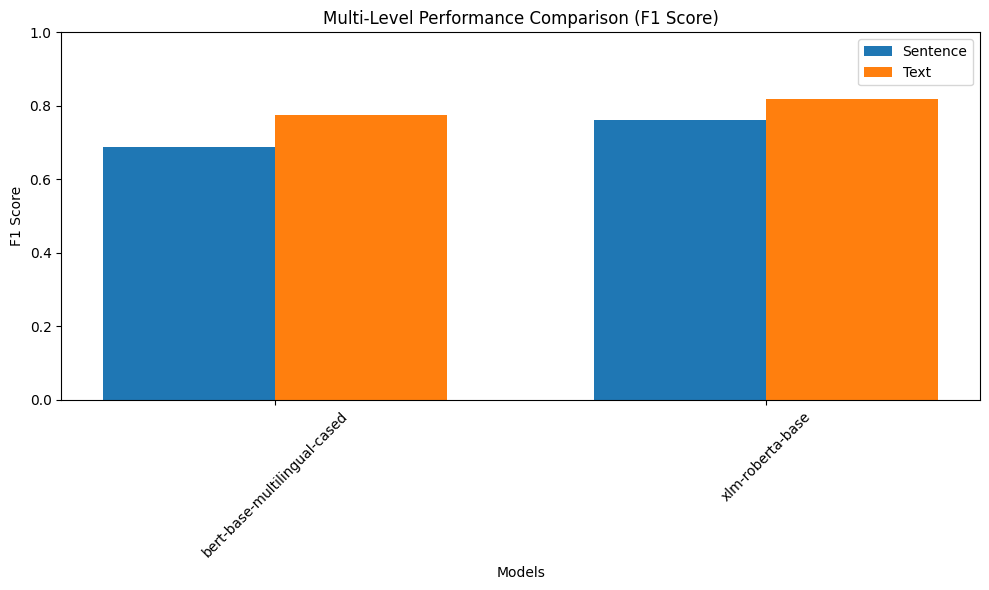

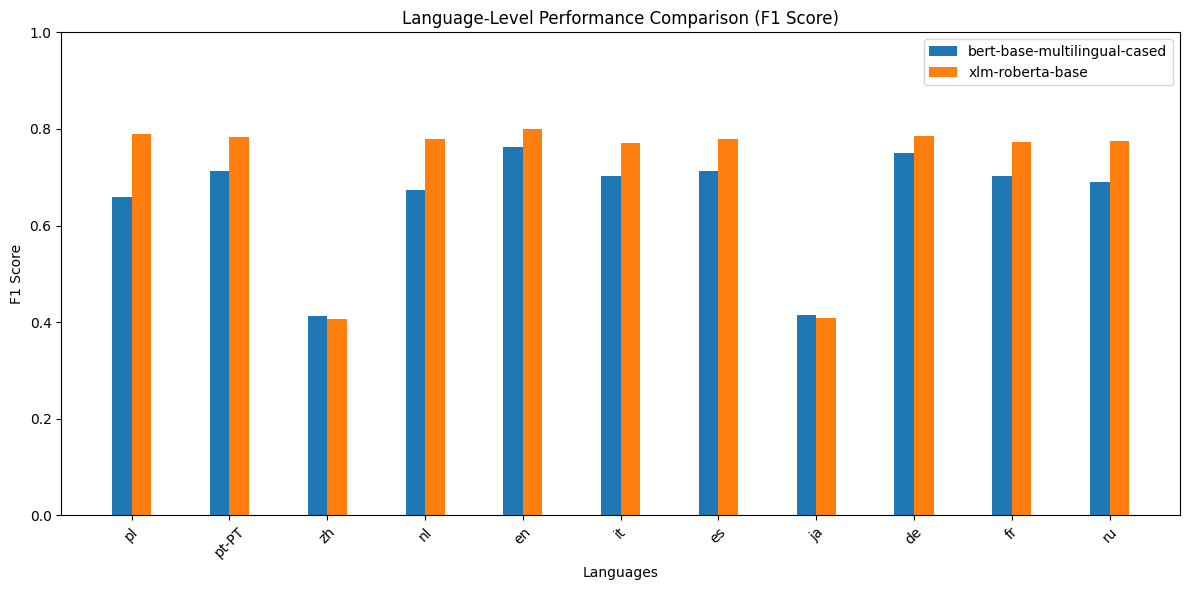

In [20]:
# Step 6: Visualize results
plot_multilevel_performance(multilevel_results)
plot_language_performance(language_results)